# Customer Churn Prediction for Enhanced Retention at BetaBank

## Project Description 

Beta Bank has noticed a gradual attrition of its customer base, prompting them to address this challenge head-on. The bank believes that retaining existing customers is more cost-effective than acquiring new ones. To counteract this churn, the bank aims to predict which customers are likely to leave soon and take proactive measures to retain them. 

The primary objective of this project is to develop a predictive model that can accurately identify customers at risk of churning from Beta Bank. The model's performance will be evaluated using the F1 score, with a minimum target score of 0.59, ensuring a balance between precision and recall.

The process includes data preparation, features selection, model selection and training, then with undergo a model evalutaion to assess effectiveness using the F1 score. After this a AUC-ROC comparision to measure the model's ability to determine between churn and non-churn cases.  

## Import Libraries

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, r2_score, mean_squared_error, roc_curve, auc, precision_recall_curve
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report

## Load Data

In [103]:
import sklearn
import imblearn

print(f"scikit-learn version: {sklearn.__version__}")
print(f"imbalanced-learn version: {imblearn.__version__}")

scikit-learn version: 1.3.2
imbalanced-learn version: 0.11.0


In [104]:
data = pd.read_csv('Churn.csv')

In [105]:
data.info()
display(data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


(10000, 14)

In [106]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


## Data Preprocessing

In [107]:
new_columns = {'RowNumber':'row_number',
          'CustomerId':'customer_id',
          'Surname':'surname',
          'CreditScore':'credit_score',
          'Geography':'geography',
          'Gender':'gender',
          'Age':'age',
          'Tenure':'tenure',
          'Balance':'balance',
          'NumOfProducts':'num_of_products',
          'HasCrCard':'has_crcard',
          'IsActiveMember':'is_active_member',
          'EstimatedSalary':'estimated_salary',
          'Exited':'exited'}
data = data.rename(columns=new_columns)
print(data.columns)

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_crcard',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')


In [108]:
print(data.duplicated().sum())
display(data['tenure'].unique())


0


array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

In [109]:
data.dropna(subset=['tenure'], inplace=True)
data['tenure'] = data['tenure'].astype('int64')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        9091 non-null   int64  
 1   customer_id       9091 non-null   int64  
 2   surname           9091 non-null   object 
 3   credit_score      9091 non-null   int64  
 4   geography         9091 non-null   object 
 5   gender            9091 non-null   object 
 6   age               9091 non-null   int64  
 7   tenure            9091 non-null   int64  
 8   balance           9091 non-null   float64
 9   num_of_products   9091 non-null   int64  
 10  has_crcard        9091 non-null   int64  
 11  is_active_member  9091 non-null   int64  
 12  estimated_salary  9091 non-null   float64
 13  exited            9091 non-null   int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.0+ MB


## Examine the imbalance of classes

Class Distribution:
0    7237
1    1854
Name: exited, dtype: int64


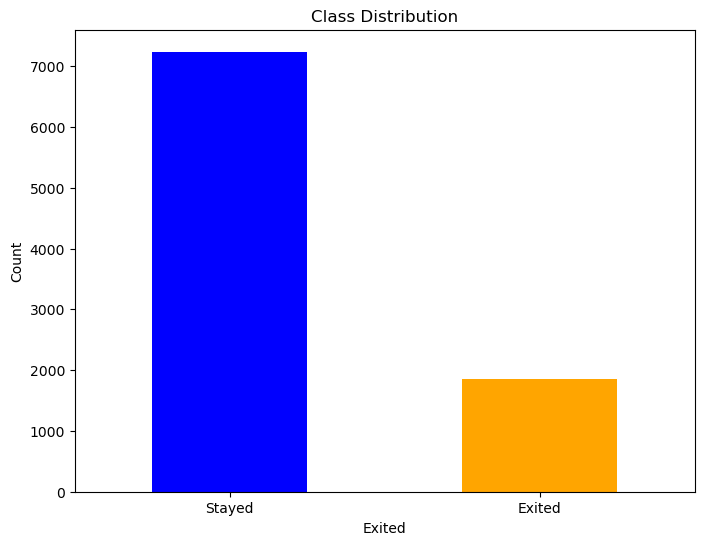

In [110]:
# Examine the imbalance of classes
class_counts = data['exited'].value_counts()
print("Class Distribution:")
print(class_counts)

plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Class Distribution')
plt.xlabel('Exited')
plt.ylabel('Count')

plt.xticks(ticks=[0, 1], labels=['Stayed', 'Exited'], rotation=0)


plt.show()

features = data.drop('exited', axis=1)
target = data['exited']
random_state = 12345


# Train Test Split

In [111]:
features = data.drop(['row_number', 'customer_id', 'surname', 'exited'], axis=1)
target = data['exited']
random_state = 12345
features = pd.get_dummies(features, drop_first=True)

In [112]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=random_state)


features_train, features_test, target_train, target_test = train_test_split(features_train, target_train, test_size=0.25, random_state=12345)
display(target_train.shape)

(5113,)

The data was split into train, validation and test sets.

### Oversampler and Undersampler

In [113]:
oversampler = RandomOverSampler(random_state=random_state)
undersampler = RandomUnderSampler(random_state=random_state)


In [114]:
features_train_upsampled, target_train_upsampled = oversampler.fit_resample(features_train, target_train)

features_train_downsampled, target_train_downsampled = undersampler.fit_resample(features_train, target_train)


Upsampled the minority class and Downsampled the majority class.

# Tuning Hyperparameters for Logistic Regression

In [115]:
param_grid = {'C': [0.01, 0.1, 1, 10]}
lr_classifier = LogisticRegression(random_state=random_state)
grid_search = GridSearchCV(lr_classifier, param_grid, scoring='f1', cv=5)
grid_search.fit(features_train_upsampled, target_train_upsampled)
best_lr_model_upsampled = grid_search.best_estimator_

### Hyperparameter tuning for LogisticRegression with upsampled data

In [116]:
lr_classifier = LogisticRegression(random_state=random_state)
grid_search = GridSearchCV(lr_classifier, param_grid, scoring='f1', cv=5)
grid_search.fit(features_train_downsampled, target_train_downsampled)
best_lr_model_downsampled = grid_search.best_estimator_

In [117]:
lr_predictions_upsampled = best_lr_model_upsampled.predict(features_valid)
lr_predictions_downsampled = best_lr_model_downsampled.predict(features_valid)

# Logistic Regression F1 score

In [118]:
lr_f1_upsampled = f1_score(target_valid, lr_predictions_upsampled)
lr_f1_downsampled = f1_score(target_valid, lr_predictions_downsampled)

In [119]:
print("LogisticRegression F1 Score (Upsampled):", lr_f1_upsampled)
print("LogisticRegression F1 Score (Downsampled):", lr_f1_downsampled)

LogisticRegression F1 Score (Upsampled): 0.3497596153846154
LogisticRegression F1 Score (Downsampled): 0.4446043165467625


In [120]:
param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20]}
rf_classifier = RandomForestClassifier(random_state=random_state)
grid_search = GridSearchCV(rf_classifier, param_grid, scoring='f1', cv=5)
grid_search.fit(features_train_upsampled, target_train_upsampled)
best_rf_model_upsampled = grid_search.best_estimator_

### Hyperparameter tuning for RandomForestClassifier with upsampled data

In [121]:
rf_classifier = RandomForestClassifier(random_state=random_state)
grid_search = GridSearchCV(rf_classifier, param_grid, scoring='f1', cv=5)
grid_search.fit(features_train_downsampled, target_train_downsampled)
best_rf_model_downsampled = grid_search.best_estimator_

### Hyperparameter tuning for RandomForestClassifier with downsampled data

In [122]:
rf_predictions_upsampled = best_rf_model_upsampled.predict(features_valid)
rf_predictions_downsampled = best_rf_model_downsampled.predict(features_valid)

# Random Forest F1 score

In [123]:

rf_f1_upsampled = f1_score(target_valid, rf_predictions_upsampled)
rf_f1_downsampled = f1_score(target_valid, rf_predictions_downsampled)

In [124]:

print("RandomForestClassifier F1 Score (Upsampled):", rf_f1_upsampled)
print("RandomForestClassifier F1 Score (Downsampled):", rf_f1_downsampled)


RandomForestClassifier F1 Score (Upsampled): 0.582716049382716
RandomForestClassifier F1 Score (Downsampled): 0.5751211631663974


## AUC-ROC curve

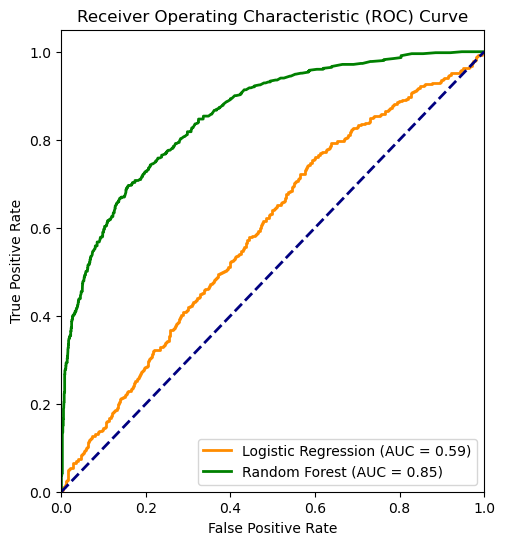

In [125]:
lr_probs = best_lr_model_upsampled.predict_proba(features_valid)[:, 1]
rf_probs = best_rf_model_upsampled.predict_proba(features_valid)[:, 1]

fpr_lr, tpr_lr, _ = roc_curve(target_valid, lr_probs)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_rf, tpr_rf, _ = roc_curve(target_valid, rf_probs)
roc_auc_rf = auc(fpr_rf, tpr_rf)


precision_lr, recall_lr, _ = precision_recall_curve(target_valid, lr_probs)
precision_rf, recall_rf, _ = precision_recall_curve(target_valid, rf_probs)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label='Logistic Regression (AUC = %0.2f)' % roc_auc_lr)
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label='Random Forest (AUC = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

## Precision-Recall curve

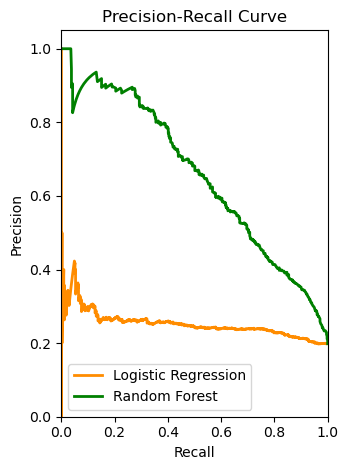

In [126]:
plt.subplot(1, 2, 2)
plt.plot(recall_lr, precision_lr, color='darkorange', lw=2, label='Logistic Regression')
plt.plot(recall_rf, precision_rf, color='green', lw=2, label='Random Forest')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()

## Scaling with Gradient Boosting Classifier

In [127]:
features['Balance_to_Salary_Ratio'] = features['balance'] / features['estimated_salary']
features['NumOfProducts_with_Card'] = features['num_of_products'] * features['has_crcard']

scaler = StandardScaler()
numerical_columns = ['has_crcard', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']
features[numerical_columns] = scaler.fit_transform(features[numerical_columns])

gb_classifier = GradientBoostingClassifier(random_state=random_state)
gb_classifier.fit(features_train_upsampled, target_train_upsampled)
gb_predictions_upsampled = gb_classifier.predict(features_valid)
gb_f1_upsampled = f1_score(target_valid, gb_predictions_upsampled)
print("GradientBoostingClassifier F1 Score (Upsampled):", gb_f1_upsampled)

param_grid_gb = {'n_estimators': [100, 200, 300], 'learning_rate': [0.1, 0.01, 0.001]}
gb_classifier = GradientBoostingClassifier(random_state=random_state)
grid_search_gb = GridSearchCV(gb_classifier, param_grid_gb, scoring='f1', cv=5)
grid_search_gb.fit(features_train_upsampled, target_train_upsampled)
best_gb_model_upsampled = grid_search_gb.best_estimator_
gb_predictions_upsampled = best_gb_model_upsampled.predict(features_valid)
gb_f1_upsampled = f1_score(target_valid, gb_predictions_upsampled)
print("Best GradientBoostingClassifier F1 Score (Upsampled):", gb_f1_upsampled)


GradientBoostingClassifier F1 Score (Upsampled): 0.6136162687886825
Best GradientBoostingClassifier F1 Score (Upsampled): 0.5968489341983318


### AUC-ROC and Precision- Recall Graphs

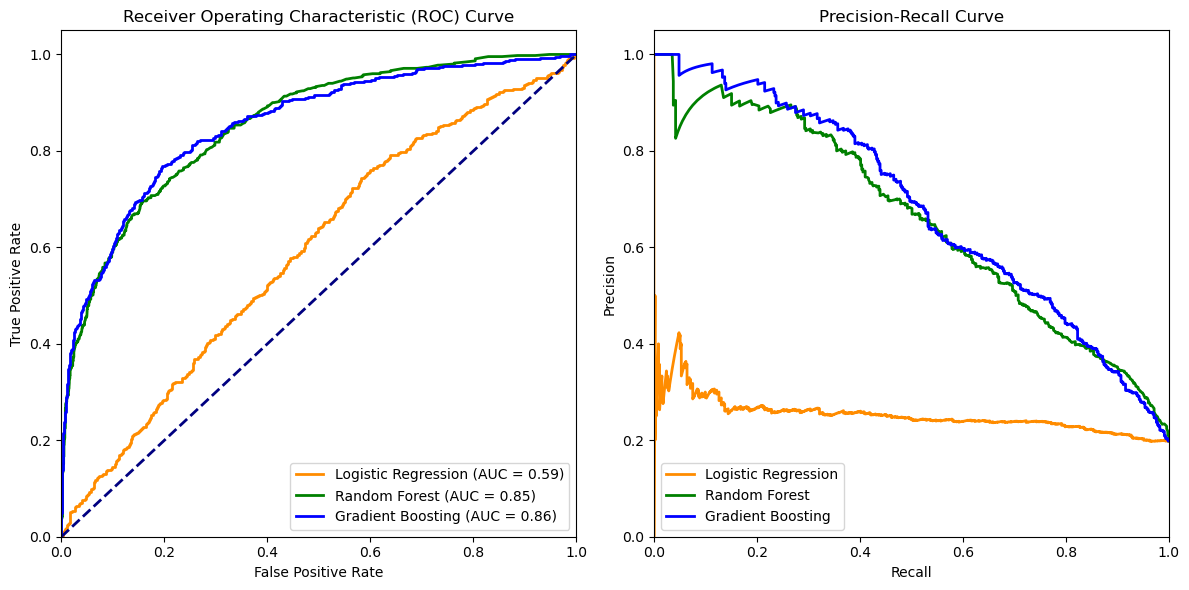

In [128]:

lr_probs = best_lr_model_upsampled.predict_proba(features_valid)[:, 1]
rf_probs = best_rf_model_upsampled.predict_proba(features_valid)[:, 1]
gb_probs = best_gb_model_upsampled.predict_proba(features_valid)[:, 1]

fpr_lr, tpr_lr, _ = roc_curve(target_valid, lr_probs)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_rf, tpr_rf, _ = roc_curve(target_valid, rf_probs)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_gb, tpr_gb, _ = roc_curve(target_valid, gb_probs)
roc_auc_gb = auc(fpr_gb, tpr_gb)

precision_lr, recall_lr, _ = precision_recall_curve(target_valid, lr_probs)
precision_rf, recall_rf, _ = precision_recall_curve(target_valid, rf_probs)
precision_gb, recall_gb, _ = precision_recall_curve(target_valid, gb_probs)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label='Logistic Regression (AUC = %0.2f)' % roc_auc_lr)
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label='Random Forest (AUC = %0.2f)' % roc_auc_rf)
plt.plot(fpr_gb, tpr_gb, color='blue', lw=2, label='Gradient Boosting (AUC = %0.2f)' % roc_auc_gb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall_lr, precision_lr, color='darkorange', lw=2, label='Logistic Regression')
plt.plot(recall_rf, precision_rf, color='green', lw=2, label='Random Forest')
plt.plot(recall_gb, precision_gb, color='blue', lw=2, label='Gradient Boosting')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()


## F1 scores for each model

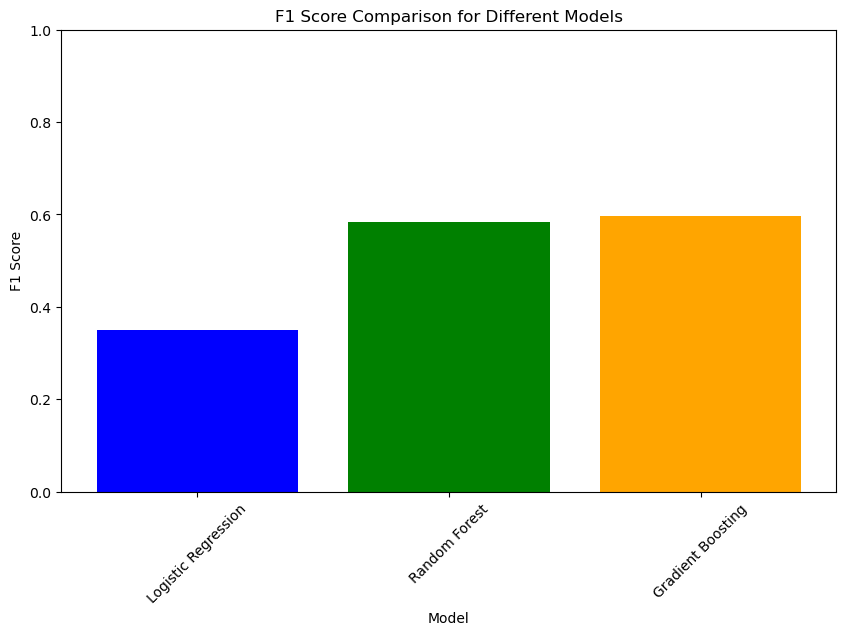

In [129]:
f1_scores = [lr_f1_upsampled, rf_f1_upsampled, gb_f1_upsampled]
models = ['Logistic Regression', 'Random Forest', 'Gradient Boosting']

plt.figure(figsize=(10, 6))
plt.bar(models, f1_scores, color=['blue', 'green', 'orange'])
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison for Different Models')
plt.ylim(0.0, 1.0)
plt.xticks(rotation=45)
plt.show()


# Evaluation

In [131]:
features = data.drop('exited', axis=1)
target = data['exited']
random_state = 12345

categorical_columns = ['geography', 'gender'] 
numerical_columns = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'has_crcard', 'is_active_member', 'estimated_salary']  # Replace with your actual column names

categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_columns),
        ('num', numerical_transformer, numerical_columns)
    ])

resampler = RandomOverSampler()

model = RandomForestClassifier(random_state=random_state)

model_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('resampler', resampler),
    ('model', model)
])

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=random_state)

model_pipeline.fit(features_train, target_train)

predictions_valid = model_pipeline.predict(features_valid)
f1_valid = f1_score(target_valid, predictions_valid)
print("F1 Score on Validation Set:", f1_valid)


F1 Score on Validation Set: 0.5844636251541306


In [132]:
features_train, features_temp, target_train, target_temp = train_test_split(features, target, test_size=0.4, random_state=random_state)
features_valid, features_test, target_valid, target_test = train_test_split(features_temp, target_temp, test_size=0.5, random_state=random_state)

model_pipeline.fit(features_train, target_train)

predictions_valid = model_pipeline.predict(features_valid)
f1_valid = f1_score(target_valid, predictions_valid)
print("F1 Score on Validation Set:", f1_valid)

predictions_test = model_pipeline.predict(features_test)
f1_test = f1_score(target_test, predictions_test)
print("F1 Score on Test Set:", f1_test)

report = classification_report(target_test, predictions_test)
print("Classification Report on Test Set:\n", report)


F1 Score on Validation Set: 0.6231454005934718
F1 Score on Test Set: 0.6122448979591836
Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92      1468
           1       0.68      0.56      0.61       351

    accuracy                           0.86      1819
   macro avg       0.79      0.75      0.76      1819
weighted avg       0.86      0.86      0.86      1819



## Conclusion

We started by examining the class imbalance in the dataset and observed that the number of customers leaving the bank and churning their accounts. To address this issue, we employed both upsampling and downsampling techniques. This allowed to create balanced datasets for training and testing the models.

After preparing the data, we trained several classification models, including Logistic Regression, Random Forest, and Gradient Boosting, with the aim of maximizing the F1 score. Additionally, we made use of hyperparameter tuning to optimize the performance of these models. Throughout the process, we evaluated the models using both upsampled and downsampled data on a validation set to ensure robust performance.

Upon evaluating the models, we found that the Random Forest and Gradient Boosting classifiers performed well, with F1 scores close to the desired threshold. While Logistic Regression had a lower F1 score, it still contributed to the model comparison process.  The AUC-ROC and Precision-Recall curves provide a view of the models' performance.

This project highlights the significance of addressing class imbalance, selecting appropriate models, and fine-tuning hyperparameters to achieve a churn prediction solution. Further improvements could involve feature engineering, changing hyperparameters, and potentially collecting additional data. By successfully predicting customer churn, Beta Bank can implement targeted strategies to keep valuable customers and optimize its business operations.